In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import time

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0"
else:  
    device = "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
dataset_location = 'C:\\Users\\Callum\\Documents\\Datasets'

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_data = torchvision.datasets.FashionMNIST(dataset_location, train=True, transform=transform,
                           target_transform=None, download=True)

test_data = torchvision.datasets.FashionMNIST(dataset_location, train=False, transform=transform,
                           target_transform=None, download=True)

print('{} training pictures, {} test pictures'.format(len(train_data), len(test_data)))

60000 training pictures, 10000 test pictures


torch.Size([64, 1, 28, 28])
torch.Size([64])


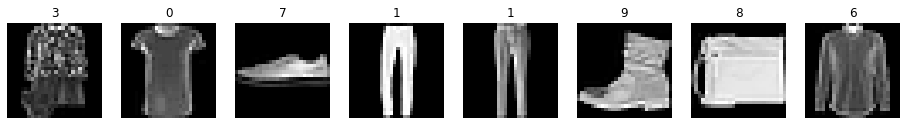

In [4]:
batch_size = 64
num_threads = 8

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)

(data, labels) = next(iter(train_loader))

img_size_flat = data.size(2)**2

print(data.size())
print(labels.size())

f, axarr = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    axarr[i].imshow(data[i][0], cmap='gray')
    axarr[i].set_title('{}'.format(labels[i]))
    axarr[i].axis('off')

In [5]:
input_size = img_size_flat
hidden_layer_size = 10
output_size = 10

scale = 0.1

w1 = torch.randn([input_size, hidden_layer_size], device=device) * scale
b1 = torch.randn([hidden_layer_size], device=device) * scale

w2 = torch.randn([hidden_layer_size, output_size], device=device) * scale
b2 = torch.randn([output_size], device=device) * scale

activation_function = nn.Sigmoid()

def activation_function_derivative(x):
    s = activation_function(x)
    return s * (1 - s)

learning_rate = 0.01

def evaluate():
    right = 0
    wrong = 0
    for batch_num, (data, labels) in enumerate(test_loader):
        batch = data.to(device)
        batch = batch.reshape([batch.size()[0], img_size_flat])

        #https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
        one_hot_labels = torch.zeros((labels.size()[0], 10), device=device)
        one_hot_labels[torch.arange(labels.size()[0]), labels] = 1

        y0 = batch
        d = one_hot_labels

        v1 = torch.mm(y0, w1) + b1
        y1 = activation_function(v1)

        v2 = torch.mm(y1, w2) + b2
        y2 = activation_function(v2)

        output = torch.argmax(y2, 1)
        
        w = torch.nonzero(labels.to(device) - output).size(0)
        wrong += w
        right += batch.size(0) - w
    
    print('{} right {} wrong {:.0f}% accuracy'.format(right, wrong, right / (right + wrong) * 100.0))

for epoch in range(5):
    for batch_num, (data, labels) in enumerate(train_loader):
        batch = data.to(device)
        batch = batch.reshape([batch.size()[0], img_size_flat])

        #https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
        one_hot_labels = torch.zeros((labels.size()[0], 10), device=device)
        one_hot_labels[torch.arange(labels.size()[0]), labels] = 1

        y0 = batch
        d = one_hot_labels

        v1 = torch.mm(y0, w1) + b1
        y1 = activation_function(v1)

        v2 = torch.mm(y1, w2) + b2
        y2 = activation_function(v2)
        
        e = d - y2
        E = torch.mean(e**2)

        delta2 = e * activation_function_derivative(v2)
        delta1 = activation_function_derivative(v1) * torch.mm(delta2, w2.T)
        
        wu = learning_rate * torch.mm(y0.T, -delta1)
        
        w1 -= wu
        b1 -= learning_rate * torch.mean(-delta1, 0)

        w2 -= learning_rate * torch.mm(y1.T, -delta2)
        b2 -= learning_rate * torch.mean(-delta2, 0)
        
    evaluate()

<ipython-input-5-c6fd6704eed6>:43: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  w = torch.nonzero(labels.to(device) - output).size(0)


6700 right 3300 wrong 67% accuracy
7322 right 2678 wrong 73% accuracy
7692 right 2308 wrong 77% accuracy
7858 right 2142 wrong 79% accuracy
7932 right 2068 wrong 79% accuracy


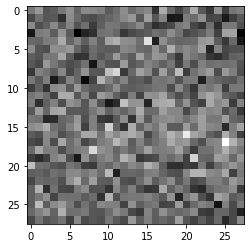

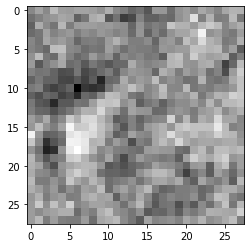

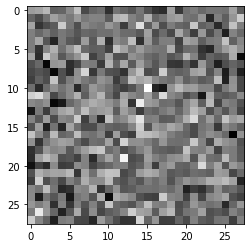

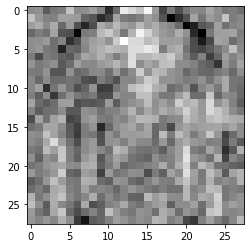

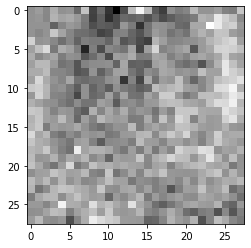

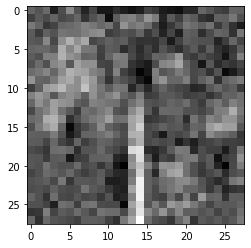

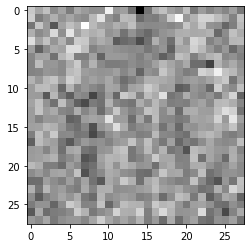

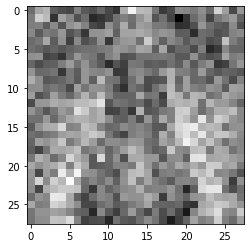

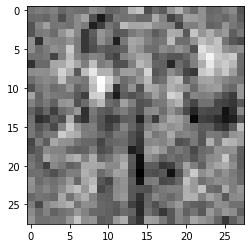

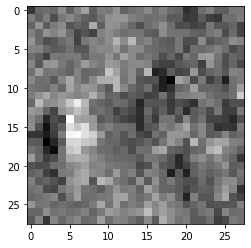

In [6]:
for i in range(10):
    plt.figure()
    plt.imshow(w1.T[i].reshape([28, 28]).cpu(), cmap="gray")

tensor(6)
torch.Size([1, 10])


RuntimeError: The size of tensor a (10) must match the size of tensor b (784) at non-singleton dimension 1

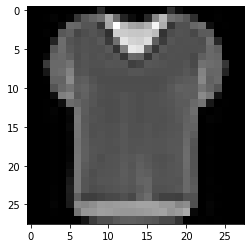

In [24]:
rand_img = data[0][0].reshape([1, img_size_flat])
rand_img = rand_img.to(device)

print(labels[0])

plt.figure()
plt.imshow(rand_img.reshape([28, 28]).cpu(), cmap="gray", vmin=0, vmax=1)

learning_rate = 1

for epoch in range(1000):
    
    one_hot_labels = torch.zeros((labels.size()[0], 10), device=device)
    one_hot_labels[torch.arange(labels.size()[0]), labels] = 1
    
    y0 = rand_img
#     d = one_hot_labels[0]
    d = torch.zeros([10], device=device)
    d[7] = 1
    
    v1 = torch.mm(y0, w1) + b1
    y1 = activation_function(v1)
    
    e = d - y1
    E = torch.mean(e**2)
    
    print(e.size())
    
    rand_img += learning_rate * 2 * e[0][7] * activation_function_derivative(v1) * w1.T
    
#     if epoch % 100 == 0:
#         print(E)
#         plt.figure()
#         plt.imshow(rand_img.reshape([28, 28]).cpu(), cmap="gray", vmin=0, vmax=1)
    
    break